# Trainable activation layer implementations

In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import logging
import inspect
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2 as cv
import os

In [ ]:
class LayerActivation(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super(LayerActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super().get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(self.units, *([1] * len(input_shape))),
        initializer="zeros",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)
  
  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      custom_objects = vars(tf.math)
      custom_objects['spatial_softmax'] = spatial_softmax
      custom_objects['spatial_softmax_2'] = spatial_softmax_2
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

In [ ]:
class KernelActivation(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super(KernelActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super(KernelActivation, self).get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    # Is conv layer
    if len(input_shape) > 2:
      self.w = self.add_weight(
          shape=(self.units, *([1] * len(input_shape[:-1])), input_shape[-1]),
          initializer="zeros",
          trainable=True,
      )
    # Is regular layer
    else:
      self.w = self.add_weight(
          shape=(self.units, *([1] * len(input_shape))),
          initializer="zeros",
          trainable=True,
      )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)

  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

In [ ]:
class NeuronActivation(keras.layers.Layer):
  def __init__(self, activation_functions, *args, **kwargs):
    super(NeuronActivation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super(NeuronActivation, self).get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        shape=(self.units, 1, *list(map(lambda shape: shape if shape is not None else 1, input_shape[1:]))),
        initializer="zeros",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)

  @classmethod
  def from_config(cls, config):
    for i, act_fn_str in enumerate(config['activation_functions']):
      config['activation_functions'][i] = keras.activations.deserialize(act_fn_str, custom_objects=vars(tf.math))
    return cls(**config)

# Functions

## Dataset functions

In [ ]:
def get_cifar10_preprocessed_data(n=None):
  from keras.preprocessing.image import ImageDataGenerator
  
  (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

  if n is not None:
    train_images = train_images[:n]
    train_labels = train_labels[:n]


  train_images = train_images.astype('float32')
  test_images = test_images.astype('float32')
  mean_image = np.mean(train_images, axis=0)
  train_images -= mean_image
  test_images -= mean_image
  train_images /= 128.
  test_images /= 128.

  return ((train_images, train_labels), (test_images, test_labels))

## Model functions

In [ ]:
class BasicModel:

    """
    # Based on work by Hein, M. et al. from https://github.com/max-andr/relu_networks_overconfident/blob/master/models.py
    """

    def __init__(self, activation_function):
        self.activation_function = activation_function

    def _batch_norm(self, X):
        X = layers.BatchNormalization(momentum=0.99, epsilon=1e-5, center=True, scale=True)(X)
        return X

    def _dropout(self, X):
        X = layers.Dropout(0.5)(X)
        return X

    def _global_avg_pool(self, X):
        assert X.get_shape().ndims == 4
        return tf.reduce_mean(X, [1, 2])

    def _residual(self, X, in_filter, out_filter, stride, activate_before_residual=False):
        if activate_before_residual:
            X = self._batch_norm(X)
            X = self.activation_function()(X)
            orig_X = X
        else:
            orig_X = X
            X = self._batch_norm(X)
            X = self.activation_function()(X)

        # Sub1
        X = self._conv(X, filter_size=3, out_filters=out_filter, stride=stride)

        # Sub2
        X = self._batch_norm(X)
        X = self.activation_function()(X)
        X = self._conv(X, filter_size=3, out_filters=out_filter, stride=1)

        #Sub Add
        if in_filter != out_filter:
            orig_X = layers.AveragePooling2D(pool_size=(stride, stride), strides=(stride, stride), padding='valid')(orig_X)
            orig_X = tf.pad(orig_X, [[0, 0], [0, 0], [0, 0],
                                     [(out_filter - in_filter) // 2, (out_filter - in_filter) // 2]])
        X = layers.Add()([X, orig_X])
        return X

    def _conv(self, X, filter_size, stride, out_filters, biases=False):
        if biases:
            X = layers.Conv2D(filters=out_filters, kernel_size=(filter_size, filter_size),
                       strides=[stride, stride], padding='same', bias_initializer=keras.initializers.Constant(0.0),
                       kernel_regularizer=keras.regularizers.l2(0.0005),
                       bias_regularizer=keras.regularizers.l2(0.0005))(X)
        else:
            X = layers.Conv2D(filters=out_filters, kernel_size=(filter_size, filter_size),
                       strides=[stride, stride], padding='same', kernel_regularizer=keras.regularizers.l2(0.0005),
                       bias_regularizer=keras.regularizers.l2(0.0005))(X)
        return X

    def _fc_layer(self, X, n_out, bn=False, last=False):
        if len(X.shape) == 4:
            n_in = int(X.shape[1]) * int(X.shape[2]) * int(X.shape[3])
            X = layers.Flatten()(X)
        else:
            n_in = int(X.shape[1])
        X = layers.Dense(n_out, kernel_initializer=tf.random_normal_initializer(stddev=np.sqrt(2.0 / n_in)),
                  bias_initializer=keras.initializers.Constant(0.0), kernel_regularizer=keras.regularizers.l2(0.0005),
                  bias_regularizer=keras.regularizers.l2(0.0005))(X)
        X = self._batch_norm(X) if bn else X
        if not last:
            X = self.activation_function()(X)
        else:
            X = layers.Activation('softmax')(X)
        return X

    def _conv_layer(self, X, size, n_out, stride, bn=False, biases=True):
        X = self._conv(X, size, stride, n_out, biases=biases)
        X = self._batch_norm(X) if bn else X
        X = self.activation_function()(X)
        return X


class ResNetSmall(BasicModel):

    """
    Based on implementation by Hein, M. et al. on the ResNetSmall model by from https://github.com/max-andr/relu_networks_overconfident/blob/master/models.py
    """

    def __init__(self, activation_function):
        super().__init__(activation_function=activation_function)
        self.n_filters = [16, 16, 32, 64]

    def load_model(self, input_shape, num_classes):
        strides = [1, 1, 2, 2]
        activate_before_residual = [True, False, False]
        n_resid_units = [0, 3, 3, 3]

        X_input = layers.Input(input_shape)
        X = self._conv(X_input, filter_size=3, out_filters=self.n_filters[0],
                       stride=strides[0])
        for i in range(1, len(n_resid_units)):
            X = self._residual(X, self.n_filters[i-1], self.n_filters[i], strides[i], activate_before_residual[0])
            for j in range(1, n_resid_units[i]):
                X = self._residual(X, self.n_filters[i], self.n_filters[i], 1, False)

        # Unit Last
        X = self._batch_norm(X)
        X = self.activation_function()(X)
        X = self._global_avg_pool(X)

        X = self._fc_layer(X, num_classes, last=True)

        model = keras.Model(inputs=X_input, outputs=X, name="ResNetSmall")

        return model

In [ ]:
def get_small_resnet(activation_function, input_shape, classes=10, lr=0.01, momentum=0.9, cyclical=False, augment=False):
  if cyclical:
    print("Using cyclical lr")
    lr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.0001,
      maximal_learning_rate=0.5,
      scale_fn=lambda x: 1/(2.**(x-1)),
      step_size=2 * (len(get_cifar100_preprocessed_data()[0][0]) // 64)
    )
  i = keras.layers.Input(shape=input_shape)

  if augment:
    print("With augment")
    x = keras.layers.experimental.preprocessing.RandomRotation(factor=0.2)(i)
    x = keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')(x)
    x = ResNetSmall(activation_function=activation_function).load_model(input_shape, classes)(x)
  else:
    x = ResNetSmall(activation_function=activation_function).load_model(input_shape, classes)(i)
    
  model = keras.models.Model(i, x)

  model.compile(
    optimizer=keras.optimizers.SGD(lr, momentum=momentum),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
  )

  return model

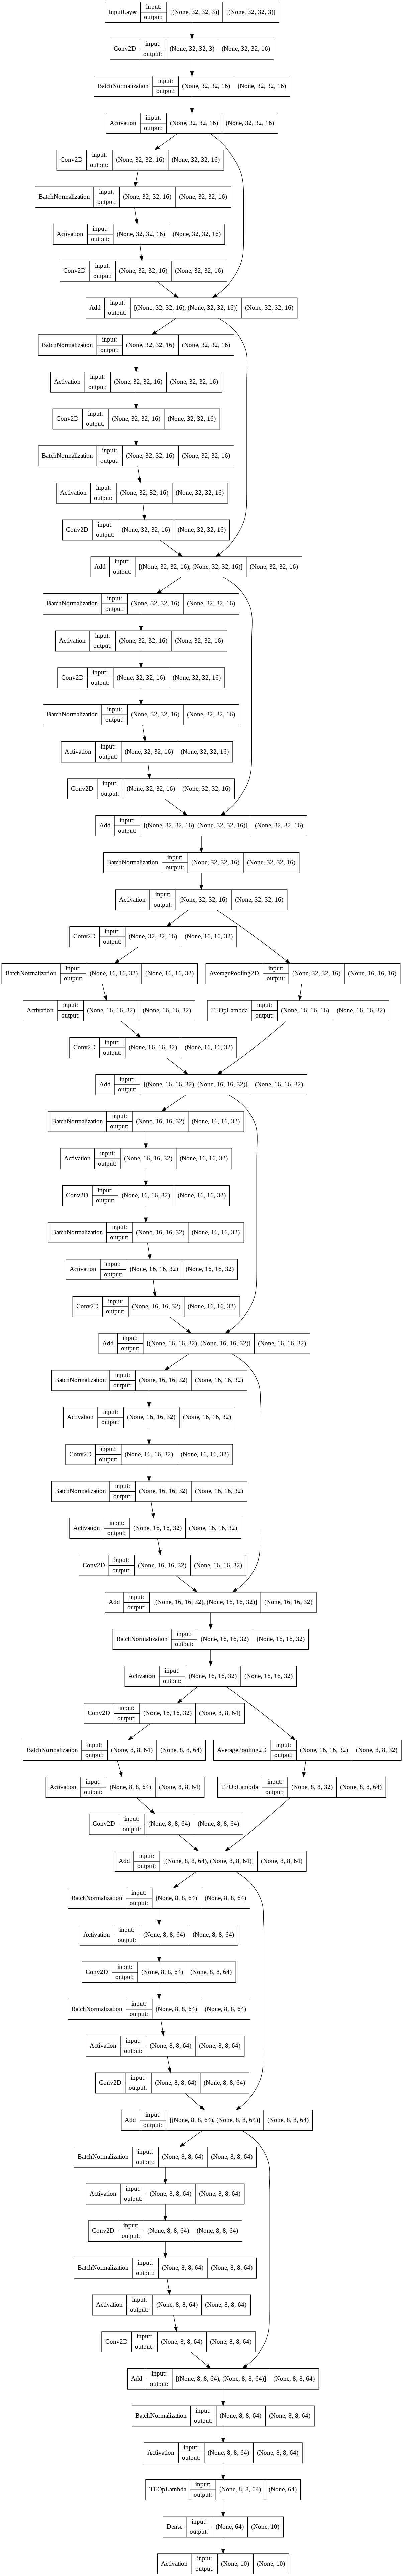

In [ ]:
model = get_small_resnet(lambda: keras.layers.Activation('relu'), input_shape=(32, 32, 3))
keras.utils.plot_model(model.layers[1], show_layer_names=False, show_shapes=True)

## Training functions

In [ ]:
import json
from google.colab import files
from sklearn.model_selection import train_test_split
from copy import deepcopy

def save_model(model, filepath, epoch):
  model_file = filepath.format(epoch=epoch + 1)
  print("Saving model to", model_file)
  print()
  models.save_model(model, model_file)

def model_train_regular(model, filepath, epochs, X, y, val_split=0.2, val_data=None, prune_model_epochs=[], callbacks=[], save=True, datagen=None):
  if save:
    callbacks += [keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max', save_weights_only=False)]
  if datagen:
    history = model.fit(
      datagen,
      validation_split=val_split,
      validation_data=val_data,
      epochs=epochs,
      callbacks=callbacks
    )
  else:
    history = model.fit(
      X, y,
      validation_split=val_split,
      validation_data=val_data,
      epochs=epochs,
      batch_size=64,
      callbacks=callbacks
    )
  return model, history

## Result plotting functions

In [ ]:
def is_activation_layer(layer):
  return 'activation' in layer.get_config()['name'] and layer.get_config().get('activation_functions', False)

In [ ]:
import math

def plot_activation_function_bars(layer):
  config = layer.get_config()

  if "wo_softmax" in layer.get_config()['name']:
    weights = tf.convert_to_tensor(layer.get_weights())
  else:
    weights = keras.activations.softmax(tf.convert_to_tensor(layer.get_weights()), axis=1)

  plt.tight_layout()
  labels = list(map(lambda fn: keras.activations.serialize(fn)[:8], layer.activation_functions))
  index = tuple([0, slice(None)] + [0] * (len(weights.shape) - 2))
  plt.xticks(rotation=45, ha="right")
  plt.ylim(0, 1.0)
  plt.bar(labels, weights[index])

def plot_activation_functions_bars(models, width=10, height=4, mode='grid', n=6, m=4):
  if not models or len(models) == 0:
    print("No models to plot for")
    return

  width = width * len(models) # width - for each model / epoch
  height = height * len([layer for layer in models[0].layers if is_activation_layer(layer)]) # height - for each layer

  plt.figure(figsize=(width, height), dpi=300)
  count = 0
  for i, model in enumerate(models):
    activation_layers = [layer for layer in models[0].layers if is_activation_layer(layer)]
    for j, layer in enumerate(activation_layers):
      if mode == 'grid':
        plt.subplot(n, m, count + 1)
      else:
        plt.subplot(len(activation_layers), len(models), count + 1)
      plot_activation_function_bars(layer)
      plt.title(f'Activation layer {j + 1}')
      # plt.title(f'Model {i + 1} Layer {layer.get_config()["name"]}')
      count += 1

  plt.show()

In [ ]:
def plot_performance(history, val_acc_label='Test accuracy', test_accuracy=None):
  plt.figure(figsize=(9,5), dpi=300)
  plt.grid(visible=True, axis='both', which='both')
  plt.yticks(np.arange(0.1, 1.1, 0.1))
  if history:
    # In case of val training
    if type(history) is list:
      epochs = range(1, len(history) + 1)
      accuracy = [metric['accuracy'] for metric in history]
      plt.plot(epochs, accuracy, label='Train accuracy')

      if 'val_accuracy' in history[0]:
        val_accuracy = [metric['val_accuracy'] for metric in history]
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
    # Regular training
    else:
      epochs = range(1, len(history.history['accuracy']) + 1)
      plt.xticks(np.arange(1, len(history.history['accuracy']) + 1, 1))
      plt.plot(epochs, history.history['accuracy'], label='Train accuracy')
      plt.plot(epochs, history.history['val_accuracy'], label = val_acc_label)
    if test_accuracy:
      plt.axhline(y=test_accuracy, label='Test accuracy', color='r', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
  else:
    print("Could not plot performance: history not available")

In [ ]:
def plot_activation_function(layer, x_start, x_end, n=None):
  config = layer.get_config()
  x = np.arange(x_start * 10, x_end * 10) / 10
  initial_x_len = x.shape[0]
  x = x.reshape(tuple([x.shape[0]] + [1] * (len(layer.weights[0].shape) - 2)))
  y = np.array(layer(x))
  plt.tight_layout()
  plt.ylim(-10, 20)
  plt.plot(x.reshape(initial_x_len), y.reshape(initial_x_len))
  if n is None:
    plt.title(config['name'])
  else:
    plt.title(f'Activation layer {n + 1}')


def plot_activation_functions(models, x_start=-20, x_end=20, width=4, height=2, mode=None):
  if not models or len(models) == 0:
    print("No models to plot for")
    return

  activation_layers = [layer for layer in models[0].layers if is_activation_layer(layer)]
  n_activation_layers = len(activation_layers)
  plt.figure(figsize=(width * len(models), height * n_activation_layers), dpi=300)
  count = 0
  for model in models:
    activation_layers = [layer for layer in model.layers if is_activation_layer(layer)]
    for i, layer in enumerate(activation_layers):
      count += 1
      if mode == 'grid':
        plt.subplot(6, 4, count)
      else:
        plt.subplot(n_activation_layers, len(models), count)
      plot_activation_function(layer, x_start, x_end, i)
  plt.show()

In [ ]:
def get_max_accuracy(history):
  if type(history) == list:
    max_test_acc = max(history, key=lambda x: x['val_accuracy'])['val_accuracy'].numpy()
    max_train_acc = max(history, key=lambda x: x['accuracy'])['accuracy'].numpy()
  else:
    max_test_acc = max(history.history['val_accuracy'])
    max_train_acc = max(history.history['accuracy'])

  return {'accuracy': max_train_acc, 'val_accuracy': max_test_acc}

## Test running functions

In [ ]:
import pickle

def save_history(filepath, history):
  try:
    filepath = filepath + '.history.pickle'
    print("Saving history to", filepath)
    pickle.dump(history, open(filepath, 'wb'))
  except Exception as e:
    print(e)

def load_history(filepath):
  try:
    filepath = filepath + '.history.pickle'
    return pickle.load(open(filepath, 'rb'))
  except Exception as e:
    print(e)

In [ ]:
def load_model(filepath):
  custom_objects = {"LayerActivationWoSoftmax": LayerActivationWoSoftmax, "LayerActivation": LayerActivation, "NeuronActivation": NeuronActivation, "KernelActivation": KernelActivation}
  with keras.utils.custom_object_scope(custom_objects):
    return models.load_model(filepath)

def load_models(filepath, epochs):
  models_list = []
  for epoch in epochs:
    models_list.append(load_model(filepath.format(epoch=epoch)))
  return models_list

def load_models_from_weights(model, filepath, epochs):
  models_list = []
  for epoch in epochs:
    cloned_model = models.clone_model(model)
    cloned_model.load_weights(filepath.format(epoch=epoch))
    models_list.append(cloned_model)
  return models_list

In [ ]:
def plot_results(
    models,
    history=None,
    do_plot_performance=True,
    do_plot_activation_function_bars=True,
    do_plot_activation_functions=True,
):
  if do_plot_performance:
    plot_performance(history)
  if do_plot_activation_function_bars:
    plot_activation_functions_bars(models)
  if do_plot_activation_functions:
    plot_activation_functions(models)

In [ ]:
def train_model(
    model,
    filepath_prefix, 
    filepath, 
    epochs,
    data,
    model_train_fn,
    use_test_as_val,
    save
):
  datagen = None
  train_X, train_y = None, None
  if type(data[0]) == keras.preprocessing.image.NumpyArrayIterator:
    datagen, (test_X, test_y) = data
  else:
    (train_X, train_y), (test_X, test_y) = data[:2]
  val_split = 0.2
  val_data = None
  if use_test_as_val:
    val_data = (test_X, test_y)
    val_split = None
  model, history = model_train_fn(model, filepath_prefix + filepath, epochs, train_X, train_y, val_split=val_split, val_data=val_data, save=save, datagen=datagen)

  if save:
    save_history((filepath_prefix + filepath).format(epoch=0), history)
  test_loss, test_acc = model.evaluate(test_X, test_y, verbose=2)
  return model, history, test_acc, test_loss

In [ ]:
def train(
    activation_function,
    filepath_prefix, 
    filepath, 
    epochs,
    get_data_fn,
    model_train_fn,
    get_model_fn=get_model,
    input_shape=None,
    use_test_as_val=False,
    save=True
  ):
  data = get_data_fn()
  if input_shape is None:
    input_shape = data[0][0].shape[1:]
  model = get_model_fn(activation_function=activation_function, input_shape=input_shape)
  return train_model(
      model,
      filepath_prefix, 
      filepath, 
      epochs,
      data,
      model_train_fn,
      use_test_as_val,
      save
  )

In [ ]:
def train_or_read(
    activation_function,
    filepath_prefix, 
    filepath, 
    epochs,
    get_data_fn,
    model_train_fn,
    get_model_fn=get_model,
    input_shape=None,
    use_test_as_val=False,
    save=True
  ):
  data = get_data_fn()
  if input_shape is None:
    input_shape = data[0][0].shape[1:]
  model = get_model_fn(activation_function=activation_function, input_shape=input_shape)
  model_name = filepath.format(epoch=epochs)
  if model_name.replace("/", "") in listdir(filepath_prefix):
    print("Reading model from file")
    # (train_X, train_y), (test_X, test_y) = data
    # train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2)
    model = load_model(filepath_prefix + model_name)
    history = load_history(filepath_prefix + filepath.format(epoch=0))
    # test_loss, test_acc = model.evaluate(test_X, test_y)
    return model, history, None, None
  else:
    print("Training model")
    return train(
      activation_function,
      filepath_prefix,
      filepath,
      epochs,
      get_data_fn,
      model_train_fn,
      get_model_fn,
      input_shape,
      use_test_as_val
    )

In [ ]:
from os import listdir
from os.path import isfile, join

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
models_path = "drive/MyDrive/master-thesis/models/experiments-resnet-1/"
listdir(models_path)

# RELU baseline

In [ ]:
relu_train_pp_output = train(
    activation_function=lambda: keras.layers.Activation(keras.activations.relu),
    filepath_prefix=models_path,
    filepath="/model-relu-pp-1-{epoch:02d}.hdf5", 
    epochs=30,
    get_data_fn=get_cifar10_preprocessed_data,
    model_train_fn=lambda *args, **kwargs: model_train_regular(*args, **kwargs, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, cooldown=0, patience=5, min_lr=0.0001)]),
    get_model_fn=get_small_resnet,
    use_test_as_val=True
)

170508288/170498071 [==============================] - 2s 0us/step
Epoch 1/30
782/782 [==============================] - ETA: 0s - loss: 1.7640 - accuracy: 0.4709
Epoch 1: saving model to drive/MyDrive/master-thesis/models/experiments-resnet-1/model-relu-pp-1-01.hdf5
782/782 [==============================] - 76s 82ms/step - loss: 1.7640 - accuracy: 0.4709 - val_loss: 1.7769 - val_accuracy: 0.5158 - lr: 0.0100
Epoch 2/30
781/782 [============================>.] - ETA: 0s - loss: 1.2754 - accuracy: 0.6522
Epoch 2: saving model to drive/MyDrive/master-thesis/models/experiments-resnet-1/model-relu-pp-1-02.hdf5
782/782 [==============================] - 63s 81ms/step - loss: 1.2754 - accuracy: 0.6521 - val_loss: 1.5615 - val_accuracy: 0.5587 - lr: 0.0100
Epoch 3/30
781/782 [============================>.] - ETA: 0s - loss: 1.0659 - accuracy: 0.7264
Epoch 3: saving model to drive/MyDrive/master-thesis/models/experiments-resnet-1/model-relu-pp-1-03.hdf5
782/782 [=============================

{'accuracy': 0.9871799945831299, 'val_accuracy': 0.8507999777793884}


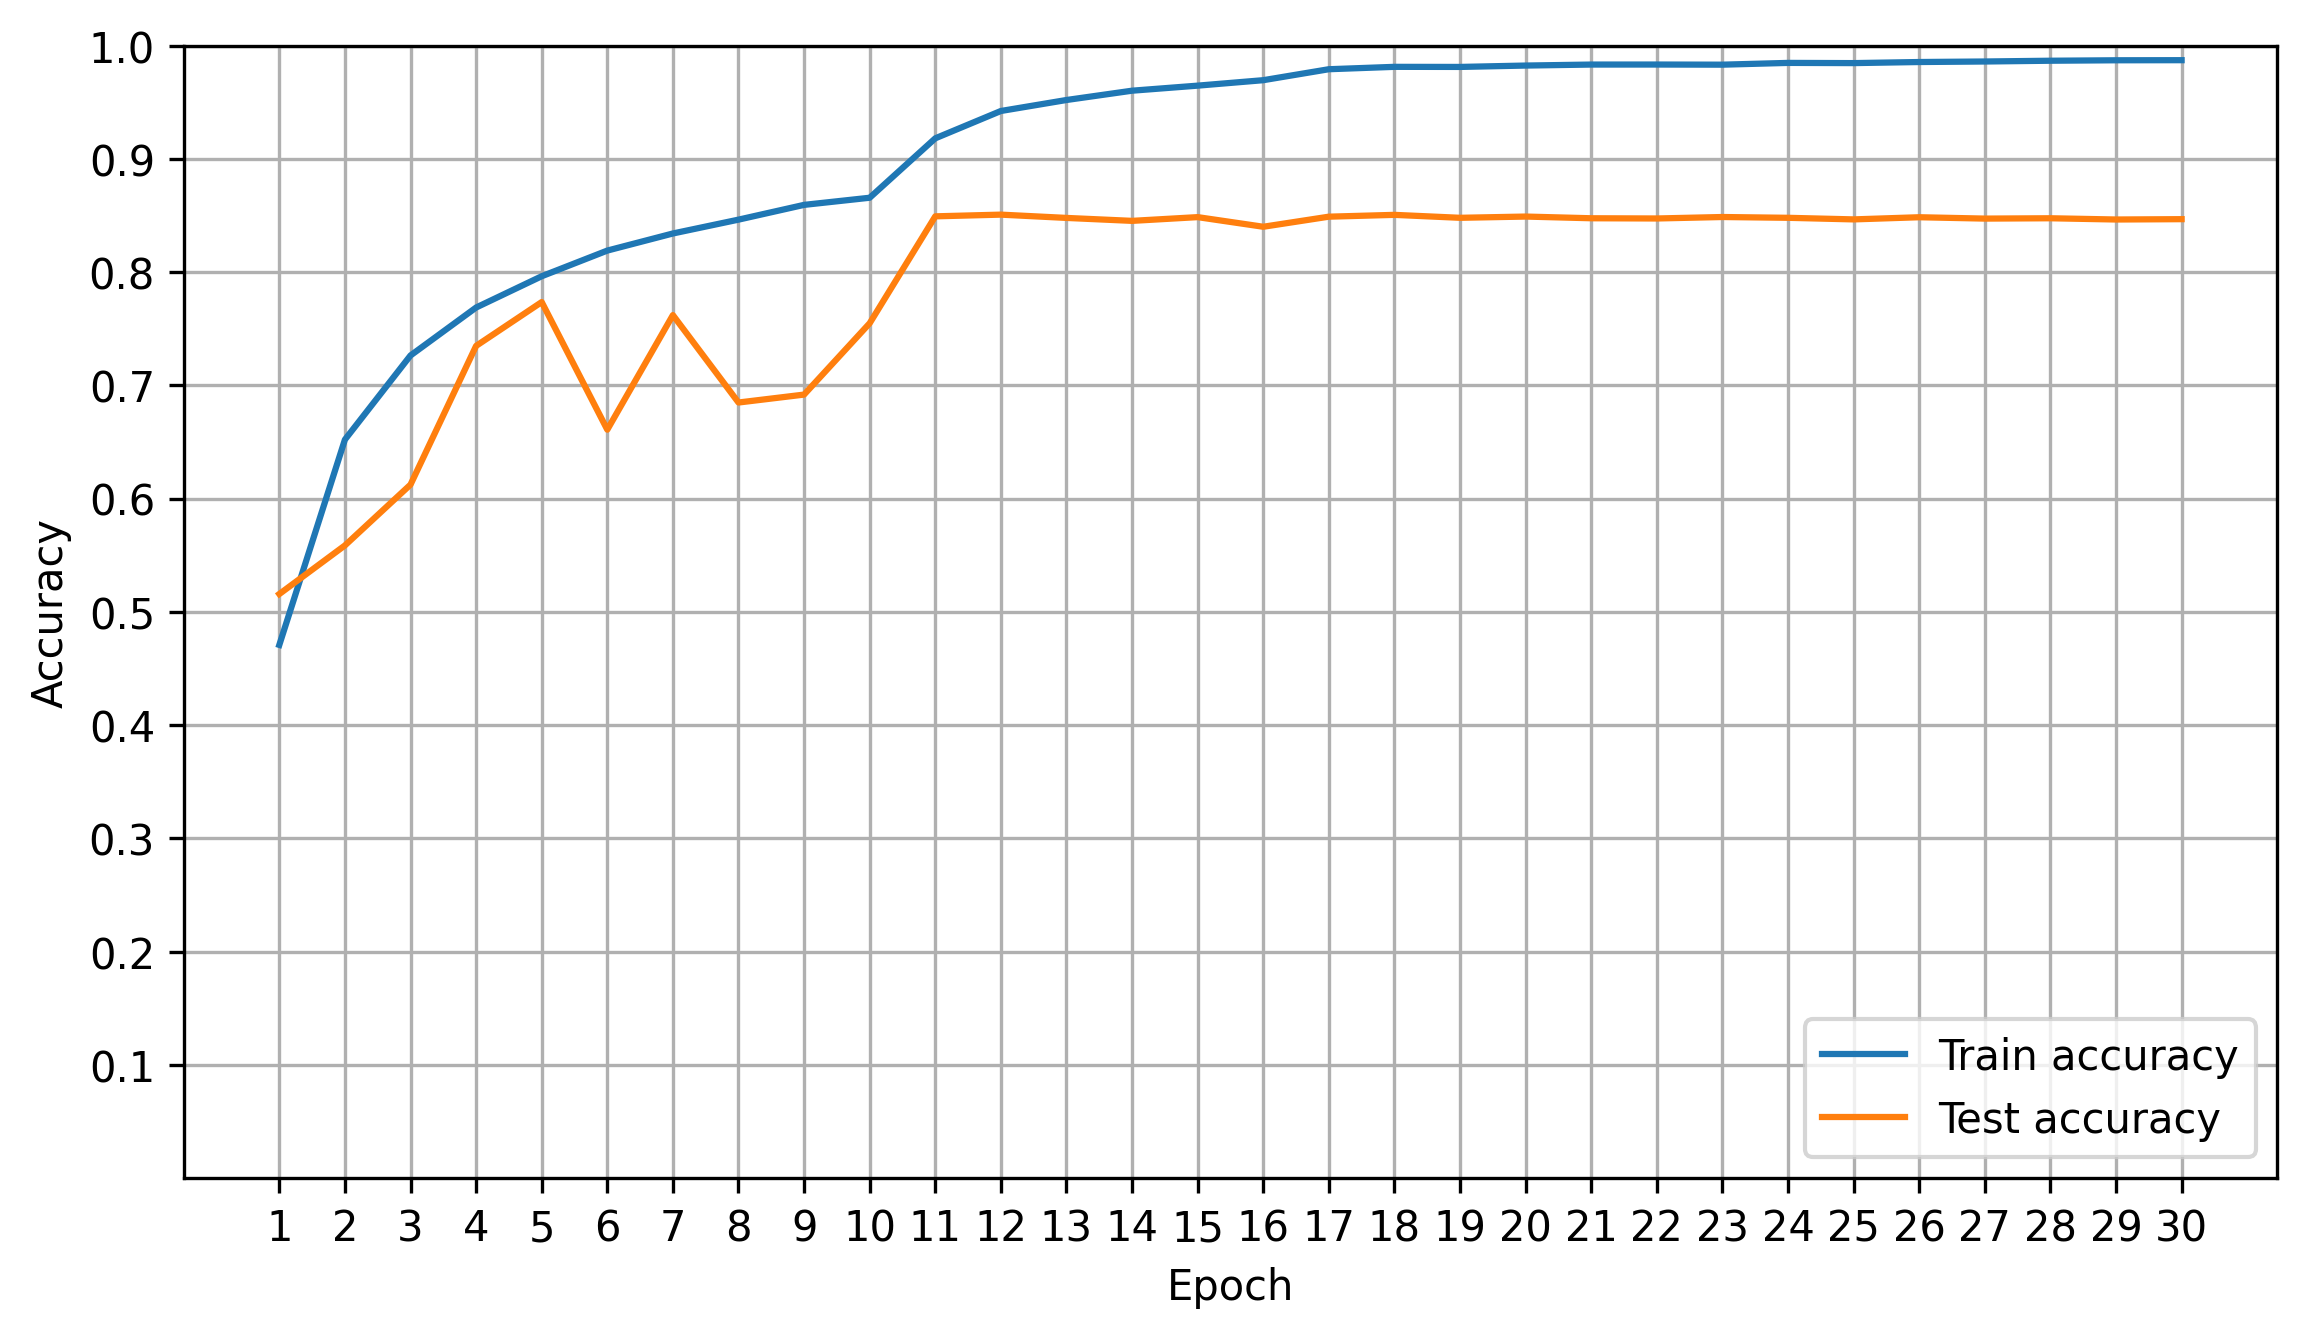

In [ ]:
model, history, test_acc, test_loss = relu_train_pp_output
print(get_max_accuracy(history))
plot_performance(history)

# Analysis

In [ ]:
import re
from collections import defaultdict

In [ ]:
train_output = open(models_path + 'train.out', 'r').read()

In [ ]:
models_output = train_output.split('Training model')
model_accuracies = defaultdict(list)

for model_output in models_output[1:]:
  epochs = model_output.replace("\x08", "").replace("[..............................]", "").split('Epoch')
  for i, epoch in list(enumerate(epochs))[1::2]:
    accuracies = re.search("accuracy: (.+) - val_loss: .+ - val_accuracy: (.+)", epoch).groups()
    key = re.search("./models-experiments-resnet/(.+)-(.+).hdf5", epochs[i + 1]).groups()
    model_accuracies[key[0]].append((int(key[1]), *tuple(map(float, accuracies))))
model_accuracies = dict(model_accuracies)

In [ ]:
model_accuracies

{'model-train-kernel-all': [(1, 0.4285, 0.379),
  (2, 0.5692, 0.5562),
  (3, 0.6202, 0.6382),
  (4, 0.6553, 0.6467),
  (5, 0.6784, 0.5691),
  (6, 0.7027, 0.6786),
  (7, 0.7232, 0.6652),
  (8, 0.7382, 0.6978),
  (9, 0.7542, 0.7087),
  (10, 0.764, 0.6853),
  (11, 0.7739, 0.7303),
  (12, 0.7849, 0.74),
  (13, 0.7917, 0.7307),
  (14, 0.8002, 0.7578),
  (15, 0.8075, 0.7546),
  (16, 0.816, 0.7763),
  (17, 0.8191, 0.7589),
  (18, 0.8234, 0.7511),
  (19, 0.8276, 0.7658),
  (20, 0.8334, 0.7691),
  (21, 0.8378, 0.7986),
  (22, 0.8429, 0.7698),
  (23, 0.8499, 0.7729),
  (24, 0.8514, 0.7849),
  (25, 0.8538, 0.7787),
  (26, 0.8591, 0.7864),
  (27, 0.9108, 0.8425),
  (28, 0.9337, 0.8436),
  (29, 0.9405, 0.8426),
  (30, 0.9455, 0.8431)],
 'model-train-kernel-basic': [(1, 0.4263, 0.3995),
  (2, 0.5585, 0.5233),
  (3, 0.6117, 0.5422),
  (4, 0.6442, 0.5804),
  (5, 0.6744, 0.659),
  (6, 0.6933, 0.6658),
  (7, 0.7097, 0.6825),
  (8, 0.729, 0.6708),
  (9, 0.7423, 0.7145),
  (10, 0.7527, 0.7205),
  (11, 0.7

In [ ]:
for model_key in model_accuracies:
  accuracies = model_accuracies[model_key]
  max_train_accuracy = max(accuracies, key=lambda x: x[1])[1]
  max_test_accuracy = max(accuracies, key=lambda x: x[2])[2]
  print(model_key.ljust(25), "max train accuracy", max_train_accuracy, "max test accuracy", max_test_accuracy)

model-train-layer-basic   max train accuracy 0.9914 max test accuracy 0.8592
model-train-layer-normal  max train accuracy 0.9867 max test accuracy 0.8512
model-train-layer-all     max train accuracy 0.9879 max test accuracy 0.8553
model-train-kernel-basic  max train accuracy 0.9318 max test accuracy 0.8385
model-train-kernel-normal max train accuracy 0.9755 max test accuracy 0.8465
model-train-kernel-all    max train accuracy 0.9455 max test accuracy 0.8436
model-train-neuron-basic  max train accuracy 0.9139 max test accuracy 0.8297
model-train-neuron-normal max train accuracy 0.9656 max test accuracy 0.8499
model-train-neuron-all    max train accuracy 0.9524 max test accuracy 0.8507


In [ ]:
output_train_layer_basic = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-basic-{epoch:02d}.hdf5", 
    epochs=30,
    get_data_fn=get_cifar10_preprocessed_data,
    model_train_fn=lambda *args, **kwargs: model_train_regular(*args, **kwargs, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, cooldown=0, patience=5, min_lr=0.0001)]),
    get_model_fn=get_small_resnet,
    use_test_as_val=True
)

Reading model from file
Ran out of input


In [ ]:
for layer in model.layers[1].layers:
  if is_activation_layer(layer):
    print(layer.get_config())

{'name': 'layer_activation_152', 'trainable': True, 'dtype': 'float32', 'activation_functions': ListWrapper([<function relu at 0x7f6912222dd0>, <function tanh at 0x7f694e31add0>, <function linear at 0x7f6912225830>, <function sigmoid at 0x7f694dbc9680>])}
{'name': 'layer_activation_153', 'trainable': True, 'dtype': 'float32', 'activation_functions': ListWrapper([<function relu at 0x7f6912222dd0>, <function tanh at 0x7f694e31add0>, <function linear at 0x7f6912225830>, <function sigmoid at 0x7f694dbc9680>])}
{'name': 'layer_activation_154', 'trainable': True, 'dtype': 'float32', 'activation_functions': ListWrapper([<function relu at 0x7f6912222dd0>, <function tanh at 0x7f694e31add0>, <function linear at 0x7f6912225830>, <function sigmoid at 0x7f694dbc9680>])}
{'name': 'layer_activation_155', 'trainable': True, 'dtype': 'float32', 'activation_functions': ListWrapper([<function relu at 0x7f6912222dd0>, <function tanh at 0x7f694e31add0>, <function linear at 0x7f6912225830>, <function sigmoi

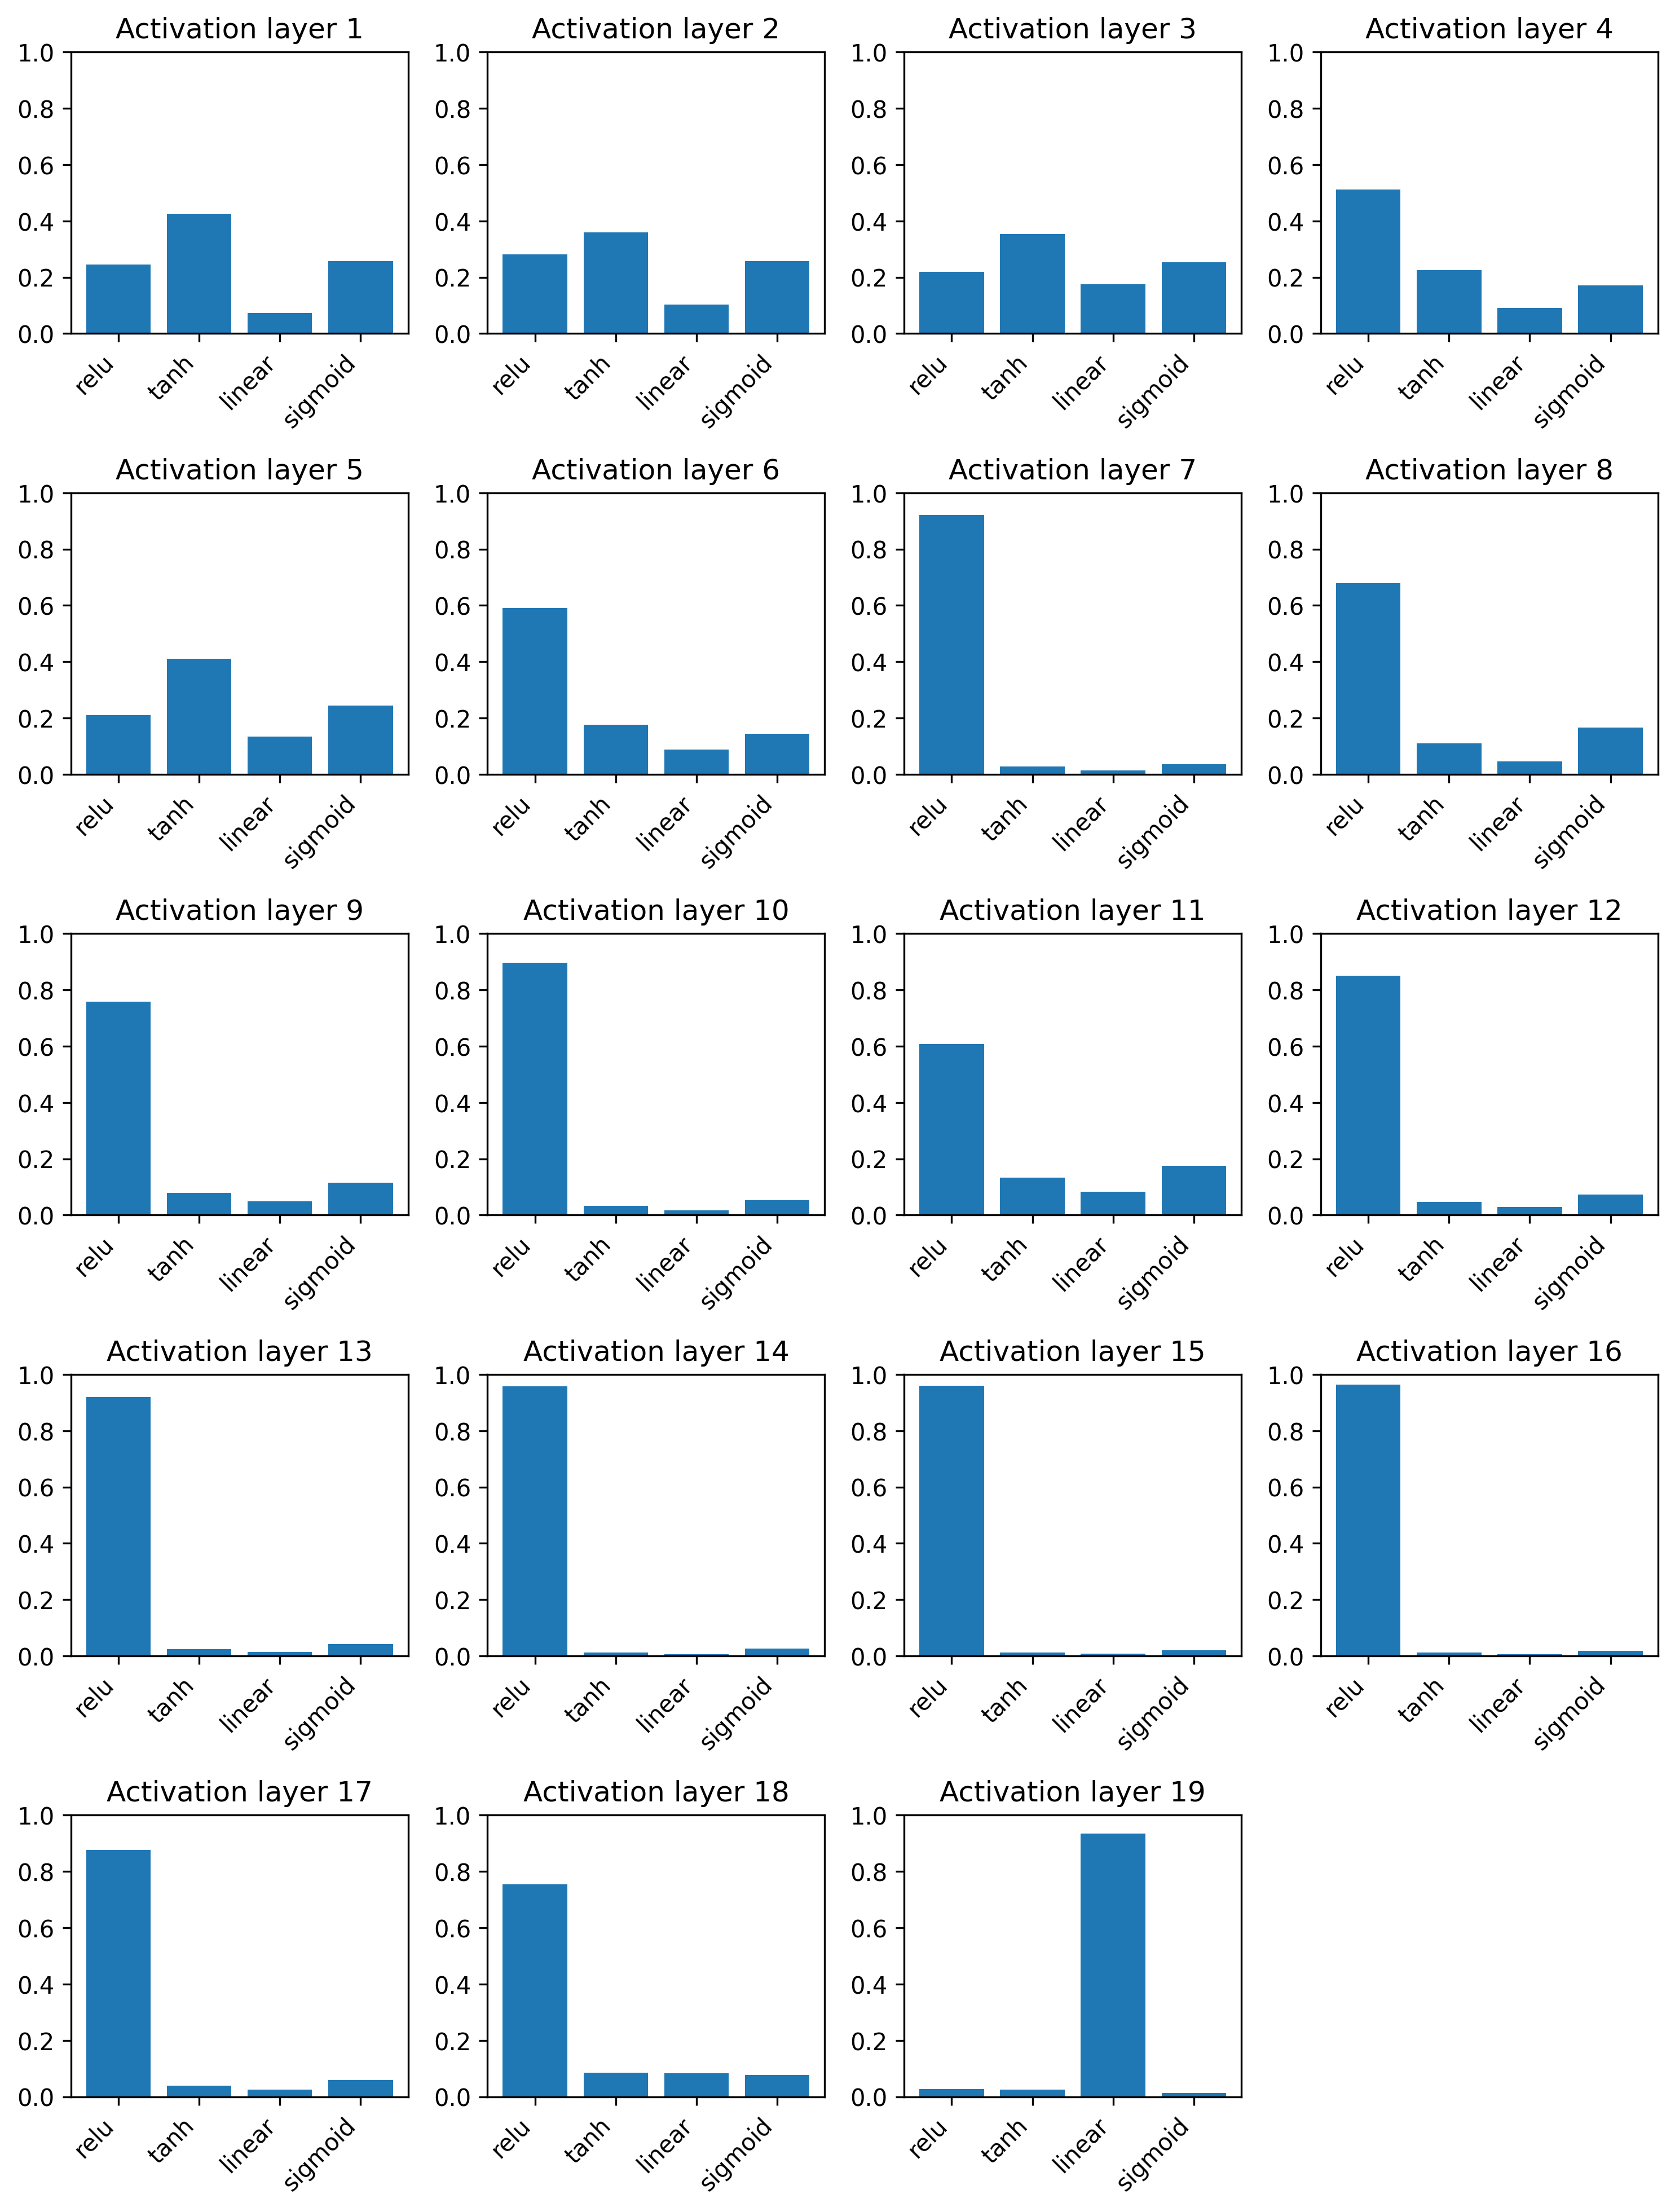

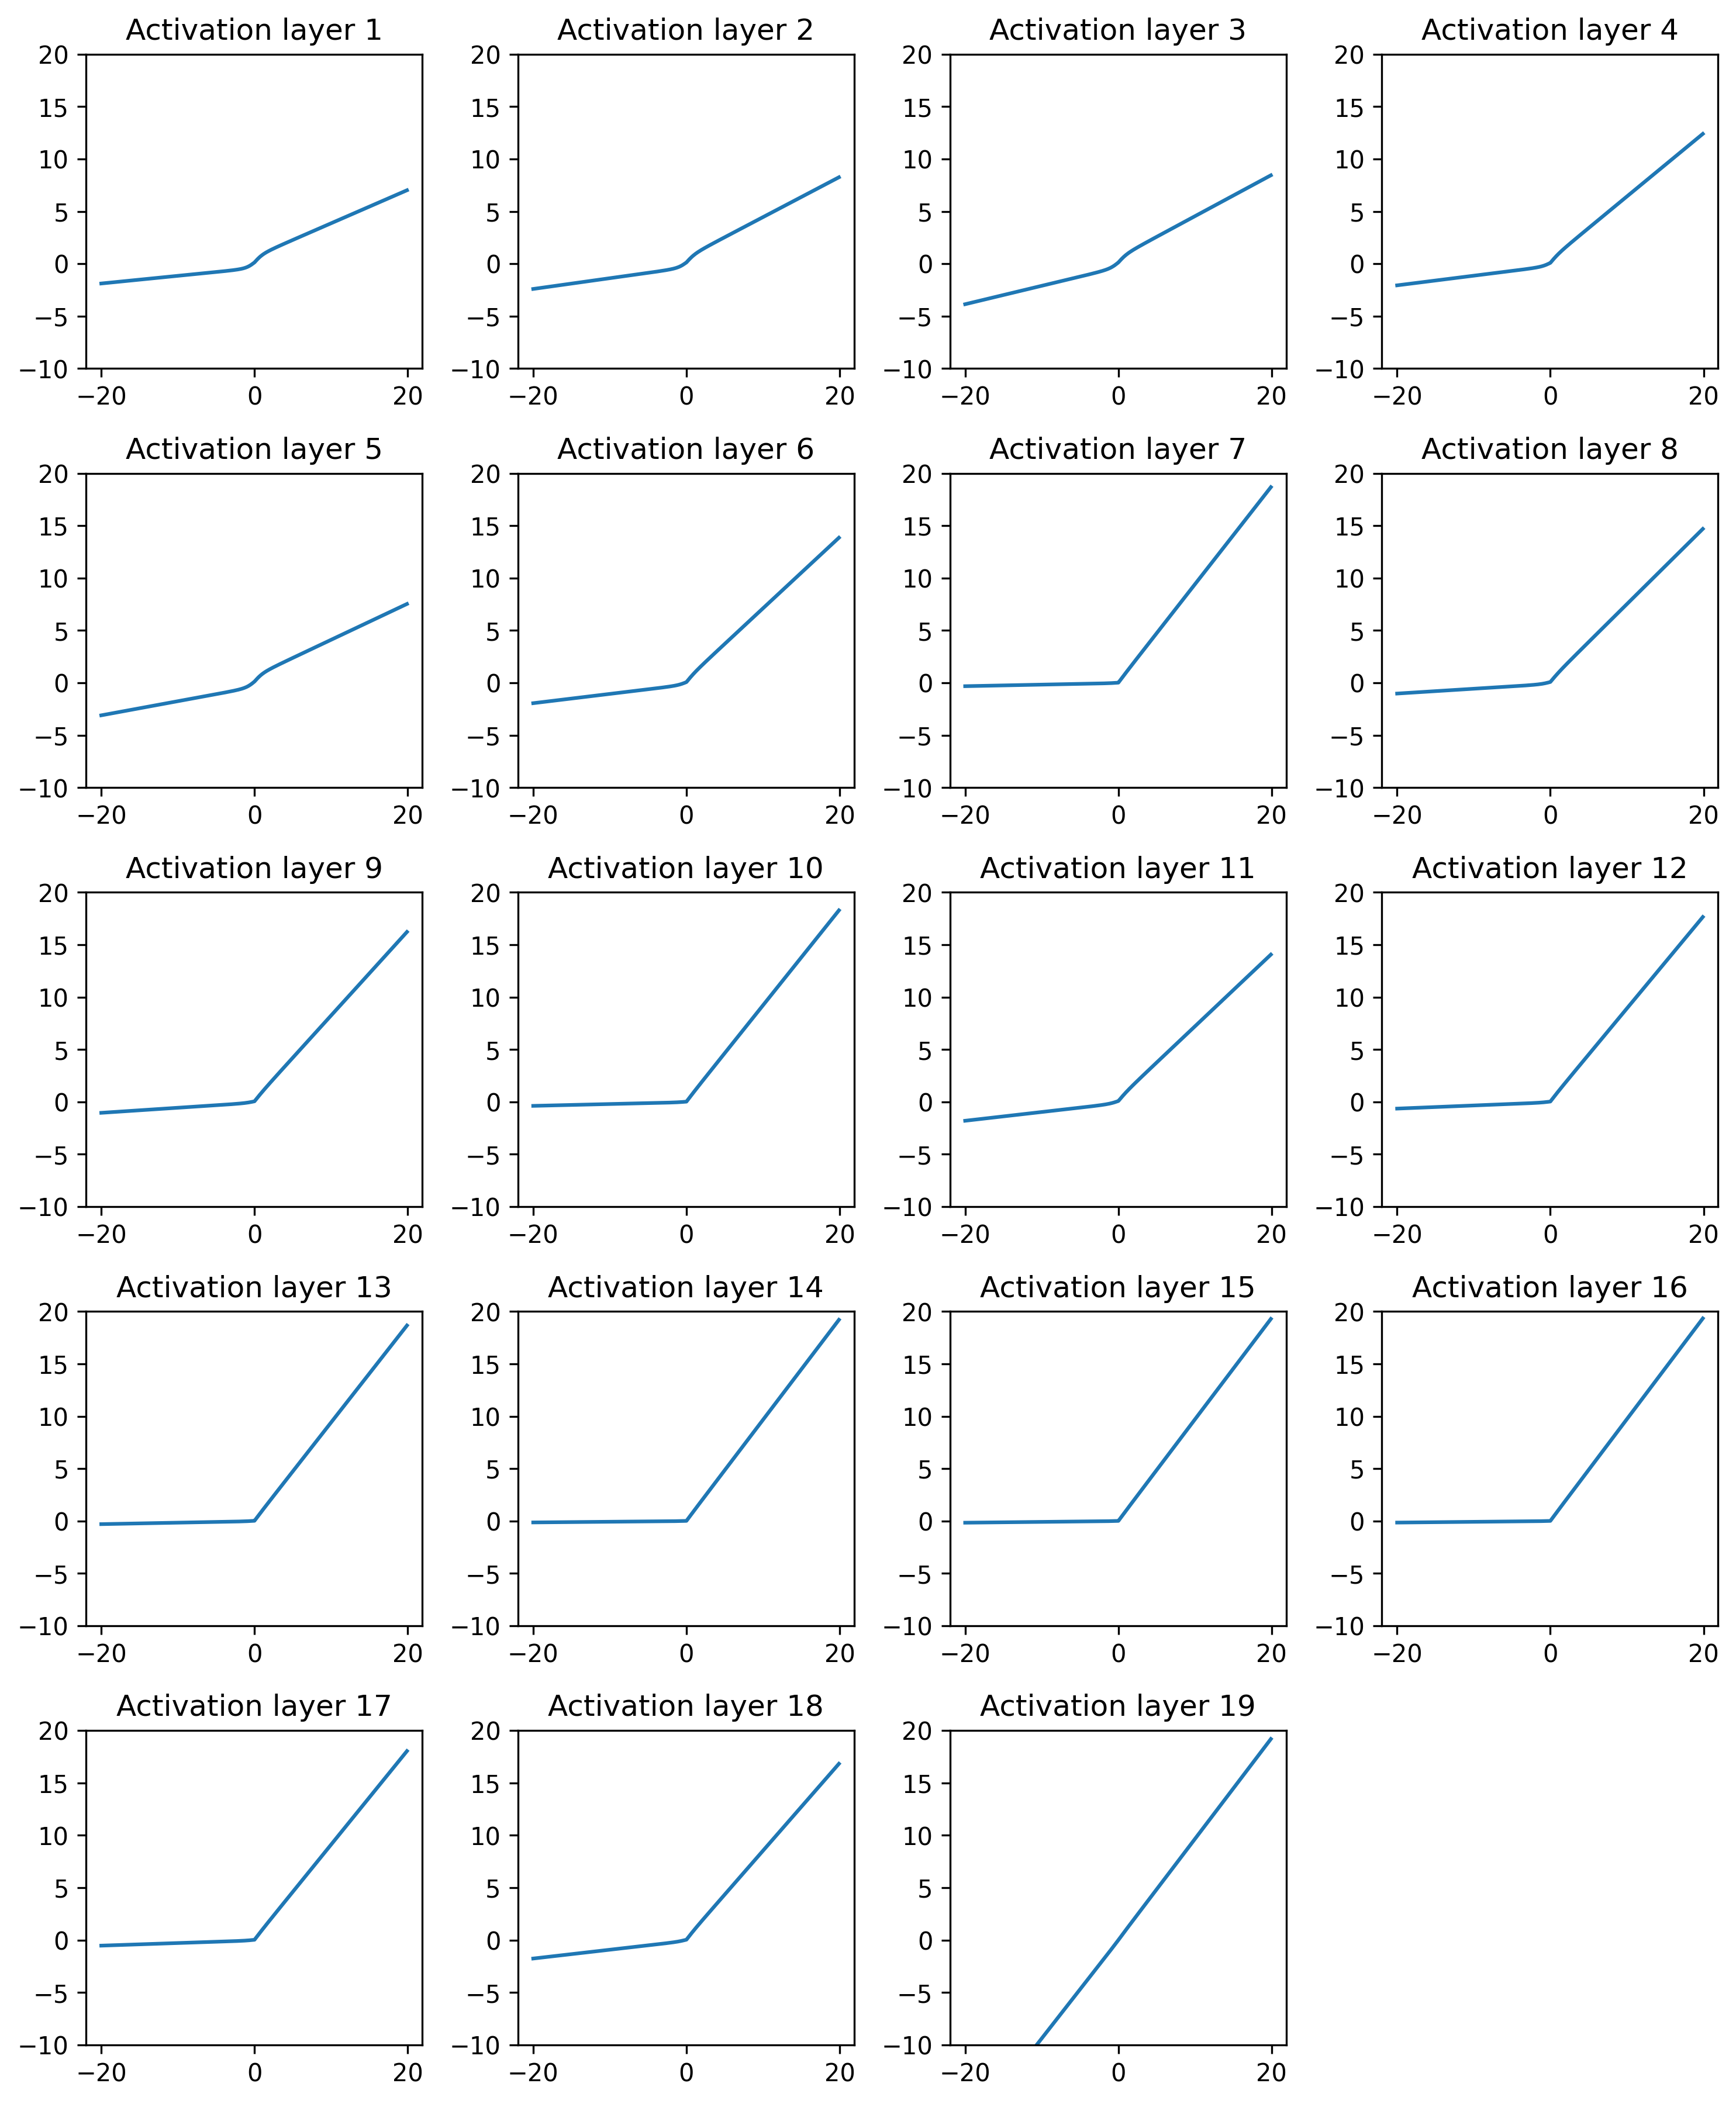

In [ ]:
model, history, test_acc, test_loss = output_train_layer_basic
plot_activation_functions_bars([model.layers[1]], width=10, height=0.8, mode='grid')
plot_activation_functions([model.layers[1]], width=10, height=0.75, mode='grid')

In [ ]:
output_train_layer_more = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-normal-{epoch:02d}.hdf5", 
    epochs=30,
    get_data_fn=get_cifar10_preprocessed_data,
    model_train_fn=lambda *args, **kwargs: model_train_regular(*args, **kwargs, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, cooldown=0, patience=5, min_lr=0.0001)]),
    get_model_fn=get_small_resnet,
    use_test_as_val=True
)

Reading model from file
Ran out of input


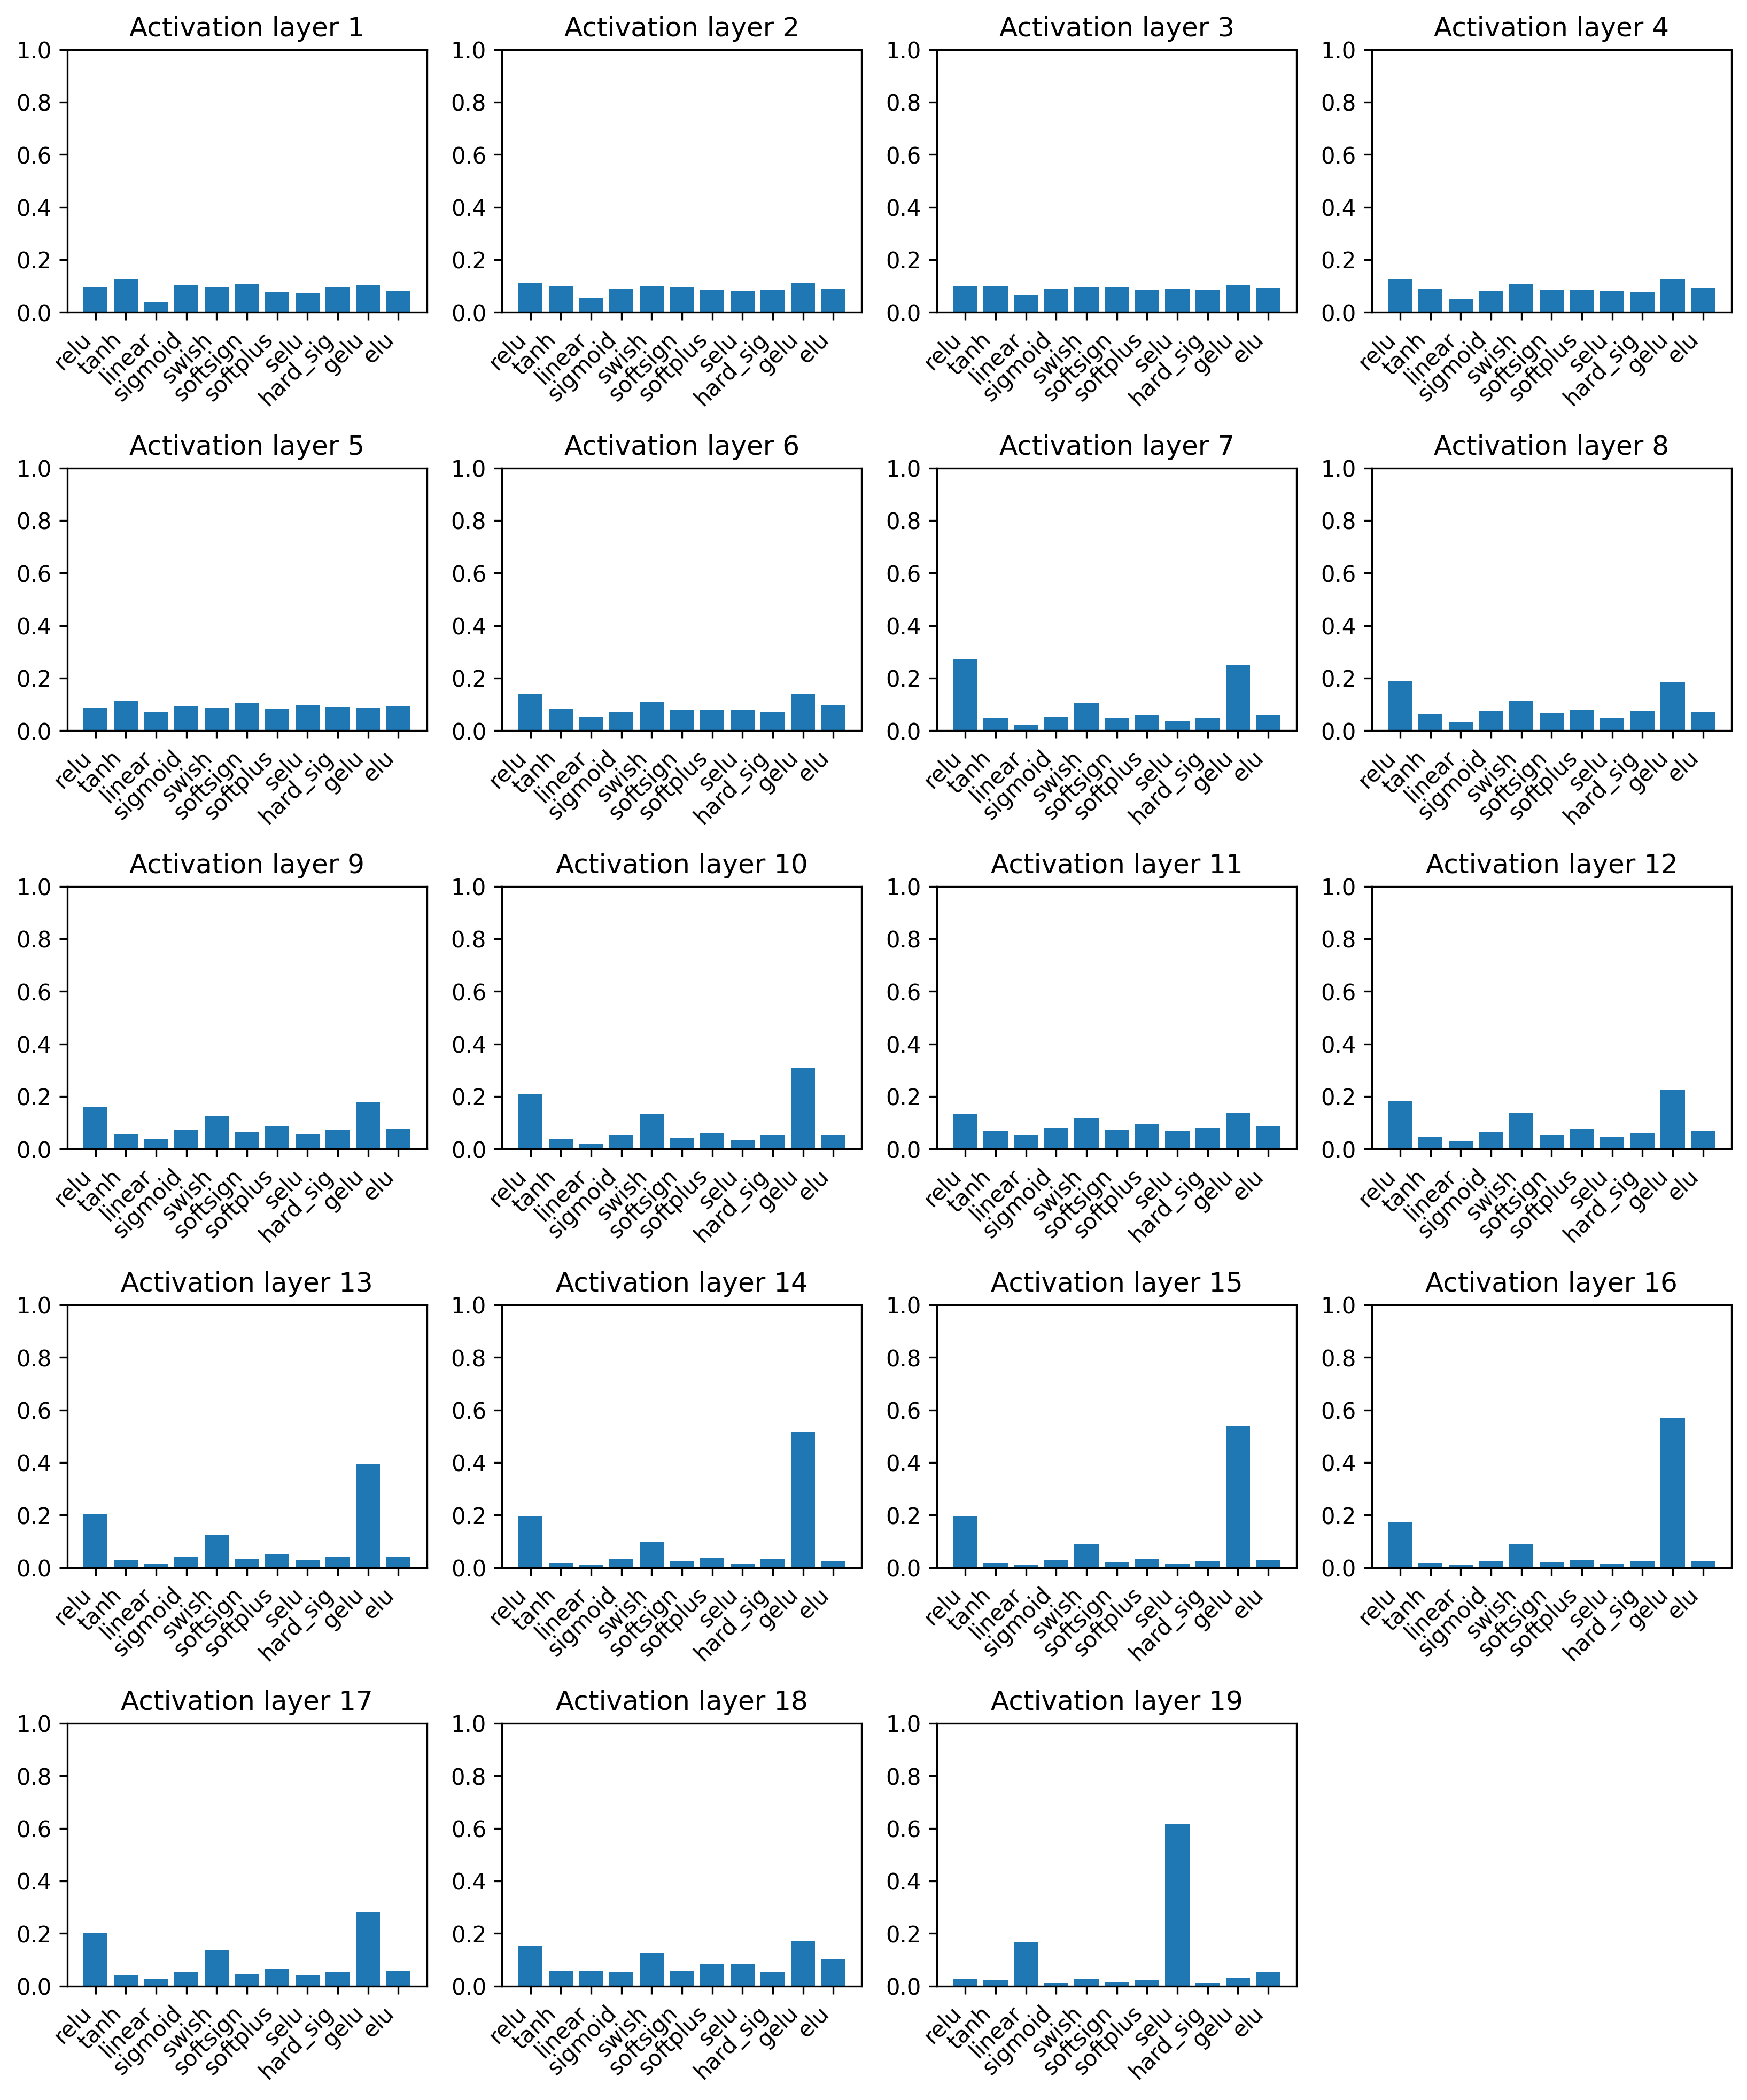

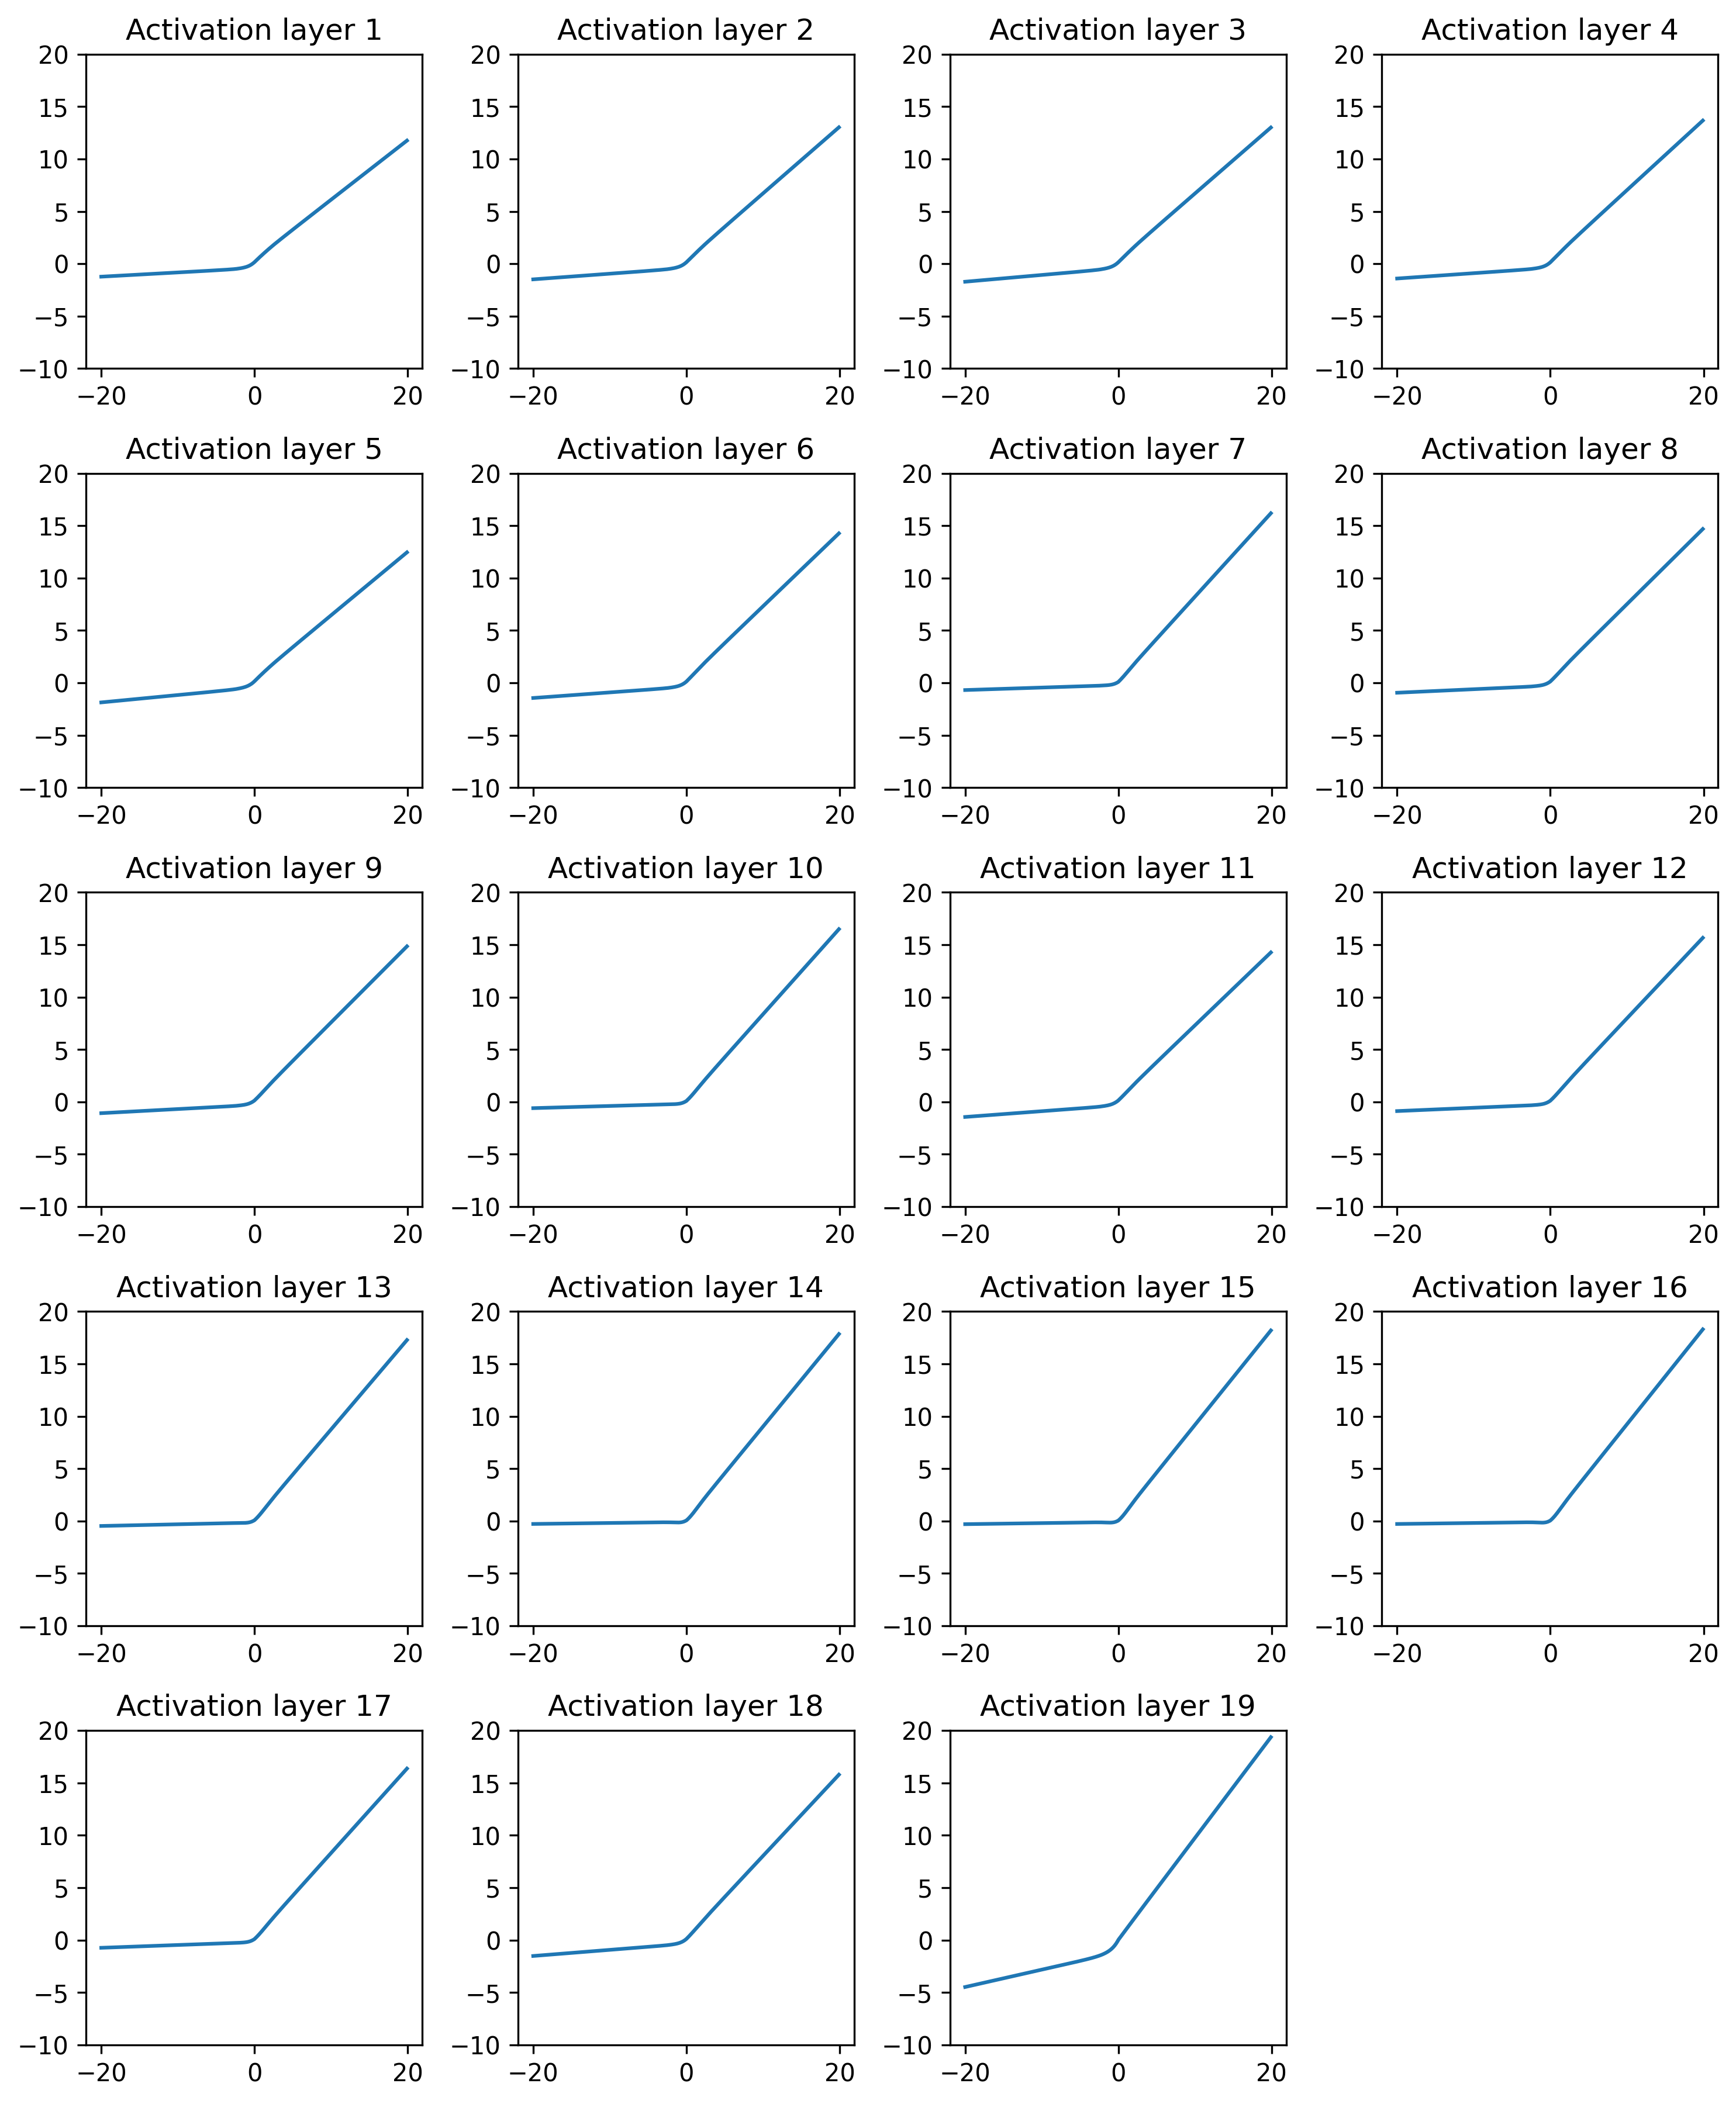

In [ ]:
model, history, test_acc, test_loss = output_train_layer_more
plot_activation_functions_bars([model.layers[1]], width=11, height=0.8, mode='grid')
plot_activation_functions([model.layers[1]], width=10, height=0.75, mode='grid')

In [ ]:
output_train_layer_all = train_or_read(
    activation_function=lambda: LayerActivation(activation_functions=[
      keras.activations.relu, 
      keras.activations.tanh, 
      keras.activations.linear,
      keras.activations.sigmoid,
      keras.activations.softmax,
      keras.activations.swish,
      keras.activations.softsign,
      keras.activations.softplus,
      keras.activations.selu,
      keras.activations.hard_sigmoid,
      keras.activations.gelu,
      keras.activations.elu,
      tf.math.sin,
      tf.math.cos
    ]),
    filepath_prefix=models_path,
    filepath="/model-train-layer-all-{epoch:02d}.hdf5", 
    epochs=30,
    get_data_fn=get_cifar10_preprocessed_data,
    model_train_fn=lambda *args, **kwargs: model_train_regular(*args, **kwargs, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, cooldown=0, patience=5, min_lr=0.0001)]),
    get_model_fn=get_small_resnet,
    use_test_as_val=True
)

Reading model from file
Ran out of input


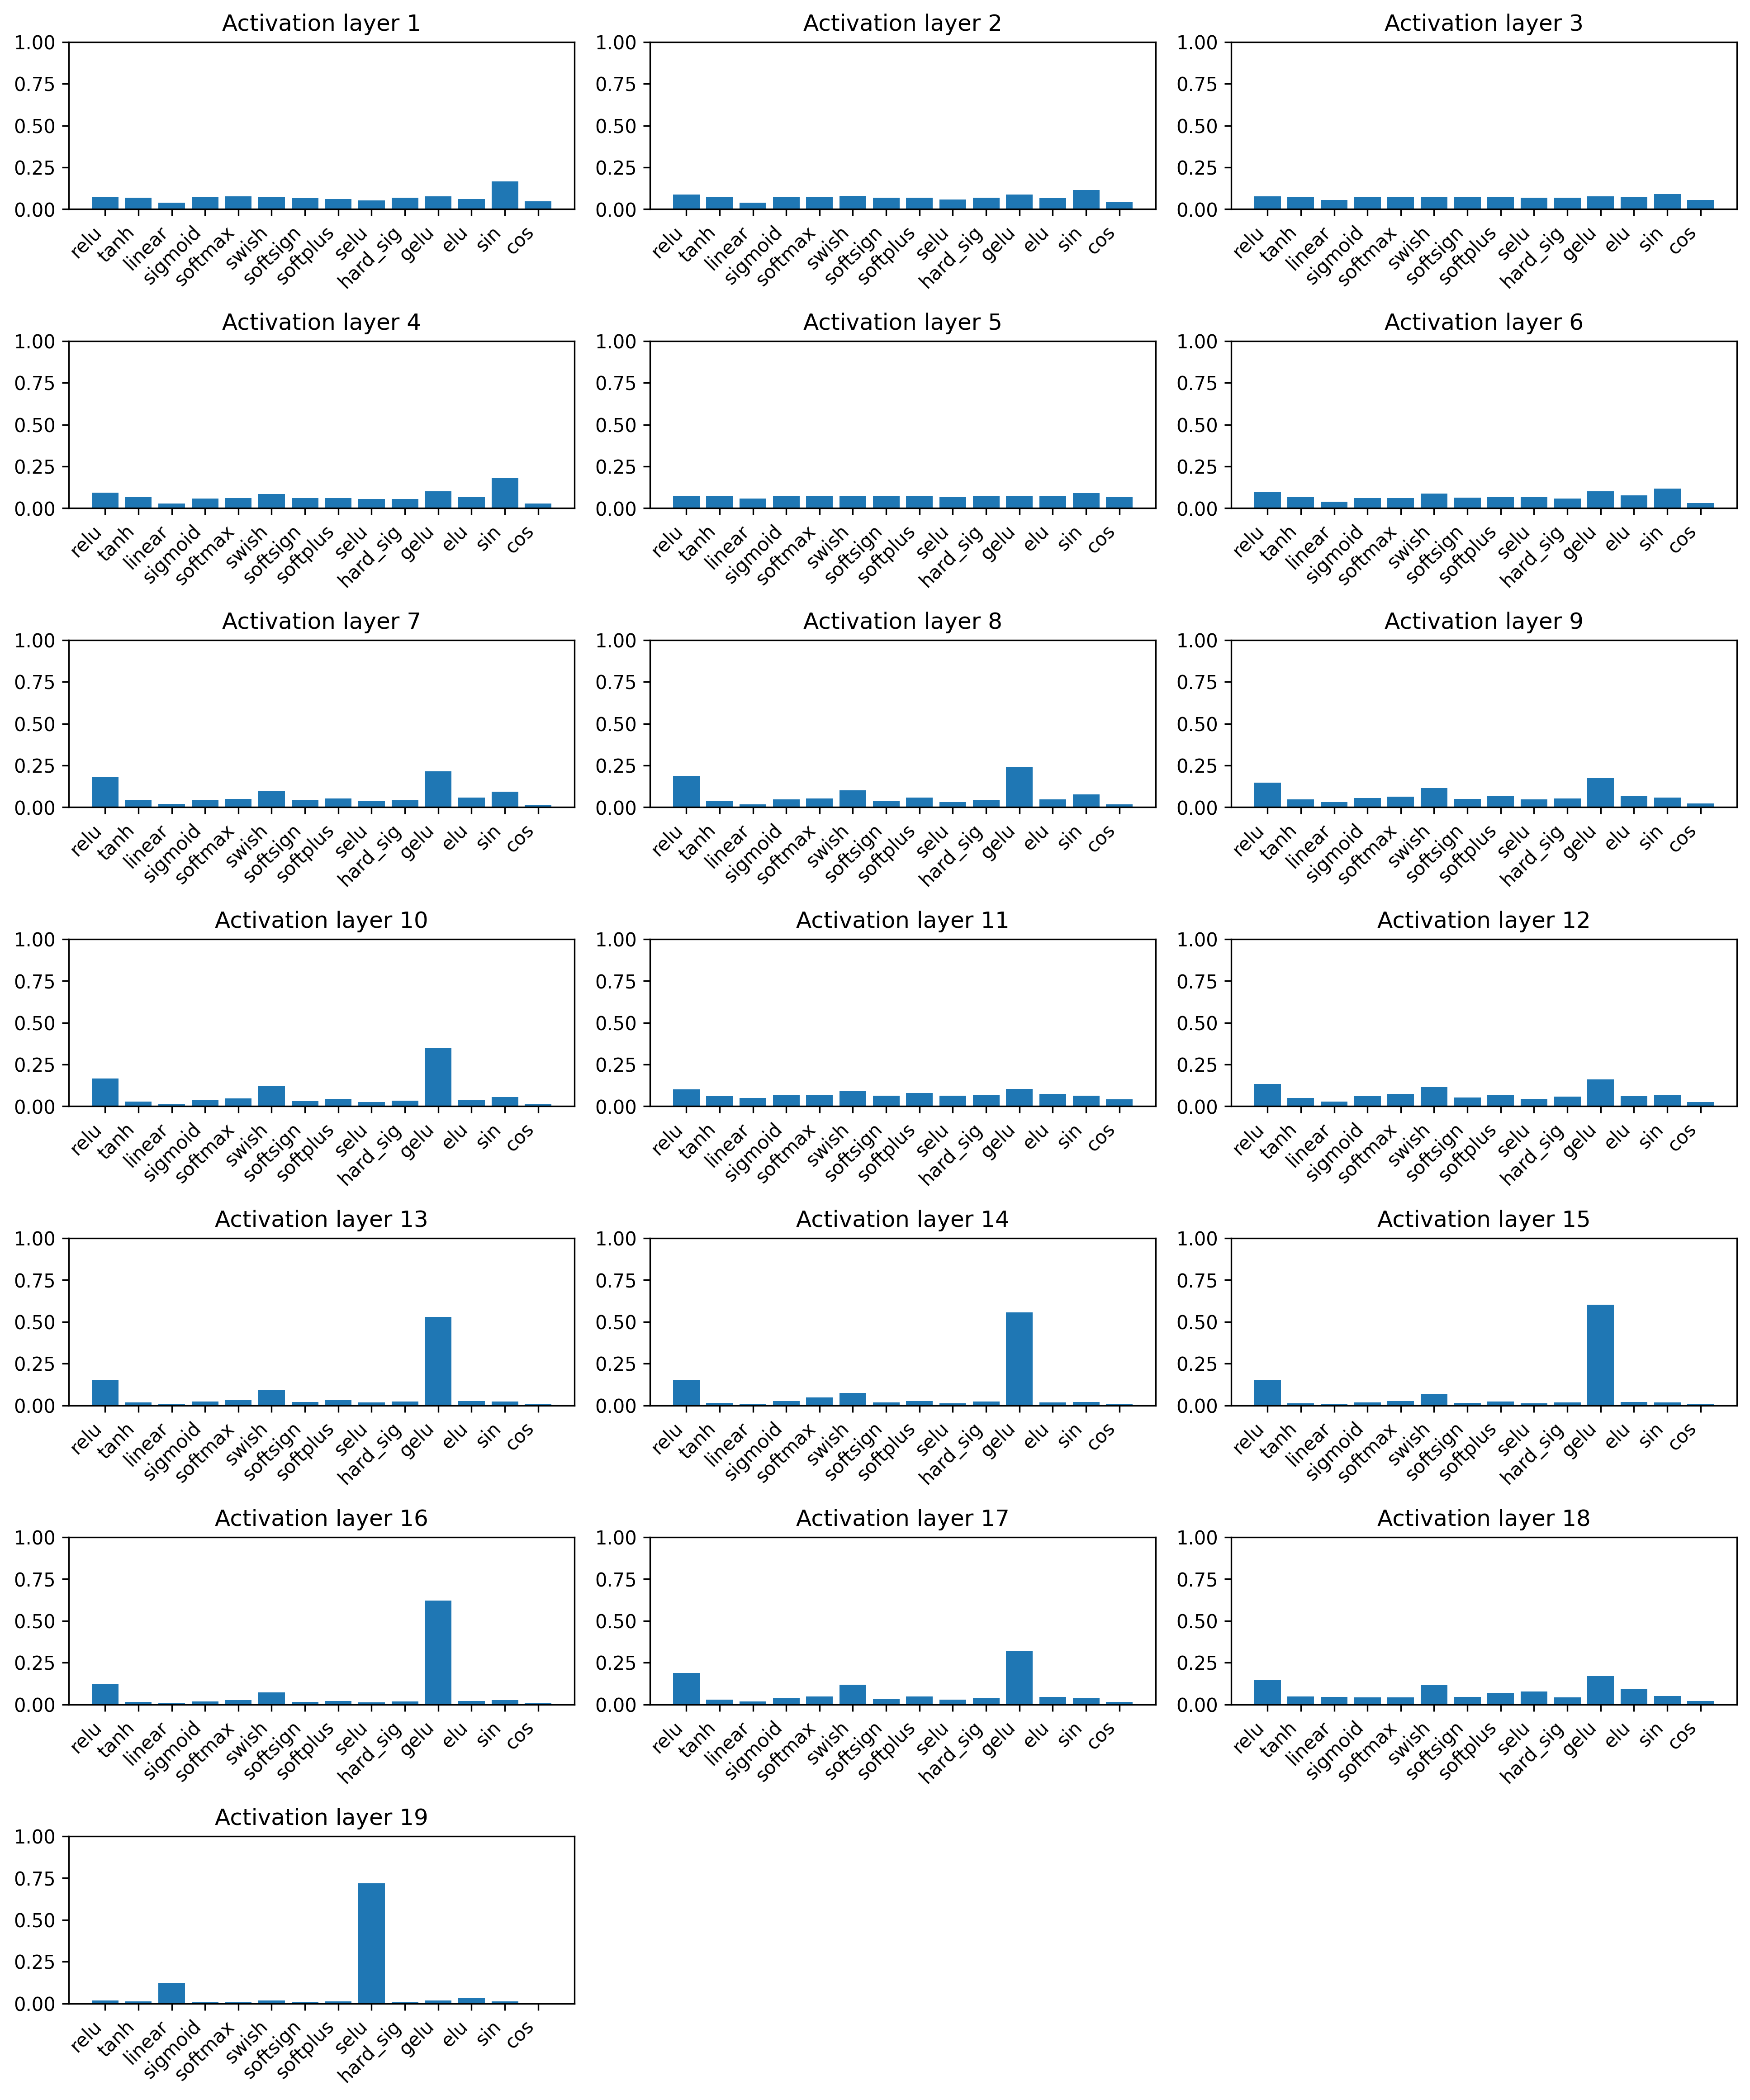

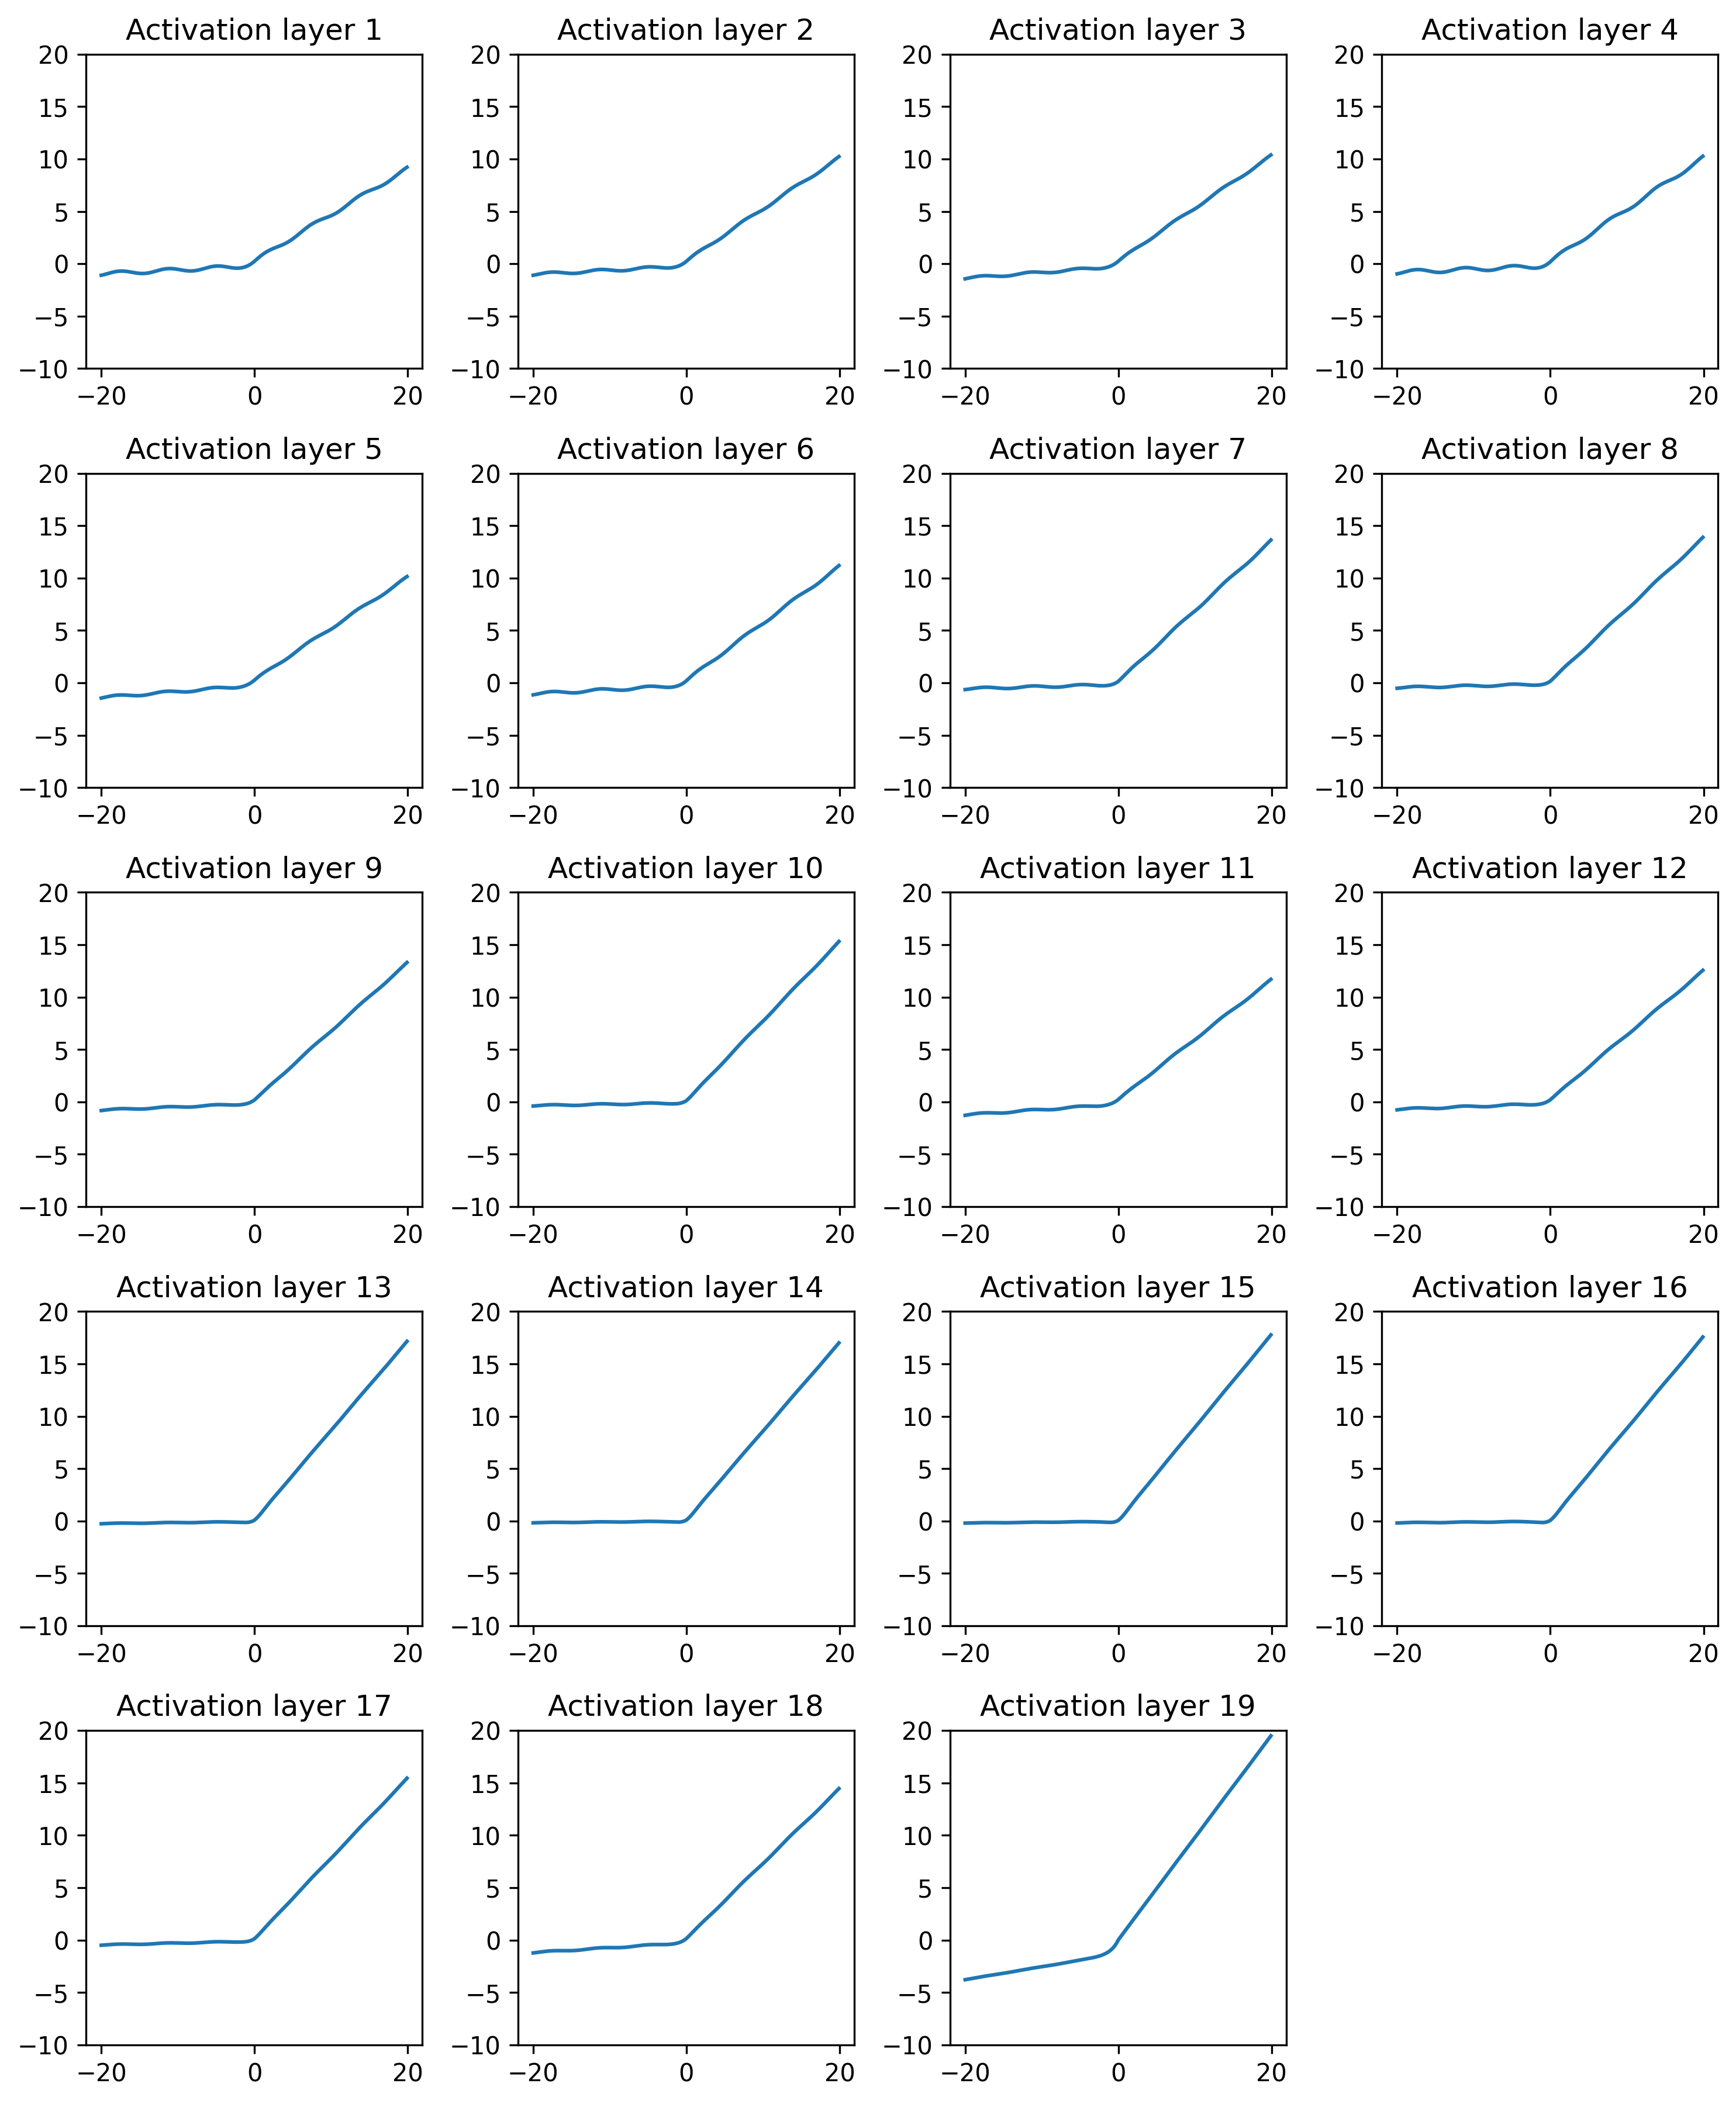

In [ ]:
model, history, test_acc, test_loss = output_train_layer_all
plot_activation_functions_bars([model.layers[1]], width=13, height=0.8, mode='grid', n=7, m=3)
plot_activation_functions([model.layers[1]], width=10, height=0.75, mode='grid')